# Сегментация пользователей в e-commerce

Онлайн магазин товаров для быта и дома "Пока все еще тут" работает как витрина товаров.  
К руководителям бизнеса пришло осознание, что лучше давать пользователям персонализированные предложения.  
Но какие предложения формулировать и по какому принципу разделить покупателей - неясно.  

**Цель проекта -** провести сегментацию пользователей и для сегментов сформулировать рекомендации, которые улучшат пользовательский опыт.  

Я располагаю данными в таблице о заказах,таблица содержит:
- Дату заказа
- ID пользователя, совершившего заказ  
- ID заказа  
- Наименование товара в заказе  
- Количество товара  
- Цена за единицу товара

Проект выполнен в несколько основных этапов:
1. Предобработка  
2. Исследовательский анализ: изучение положения магазина, покупателей и товарных категорий  
3. Выбор метода сегментации пользователей и изучение сегментов  
4. Статистическая проверка гипотез  
5. Формулирование рекомендаций  

С основным содержанием этапов и выводами проекта можно ознакомиться в [презентации](https://disk.yandex.ru/i/cVCwAYGe8dYSLw)

В первую очередь загружу библиотеки для работы

In [45]:
# Для работы с таблицами
import pandas as pd 

# Для некоторых вычислений
import numpy as np

# Для визуализации
import matplotlib.pyplot as plt 
import seaborn as sns

# Для категоризации
from nltk.corpus import stopwords # для удаления стоп-слов
import pymorphy2 # для лемматизации
from sklearn.feature_extraction.text import TfidfVectorizer # для извлечения признаков
                                                            # из текста с использованием
                                                            # метода TF-IDF
from sklearn.cluster import KMeans # для кластеризации данных методом K-средних
from sklearn.metrics import silhouette_score # для метода силуэта

# Для статистической проверки гипотез
import scipy.stats as st

Для графиков сразу задам стиль с сеткой, чтобы легче ориентироваться в числовых значениях на осях.

In [2]:
sns.set_style('whitegrid')

## Предобработка

### Знакомство с данными, переименование столбцов

Данные получу из csv файла. Сохраню его в переменную `orders`

In [3]:
orders = pd.read_csv('/datasets/ecom_dataset_upd.csv')

Посмотрю как выглядят исходные данные

In [4]:
orders.head(3)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0


Сразу замечу формат даты, в которую входит час покупки. Столбец с чистой датой я создам позже. А существующий, поскольку он содержит время - переименую в `timestamp`

In [5]:
orders = orders.rename(columns={'date':'timestamp'})

### Форматы данных и пропуски

С помощью специального метода посмотрю форматы данных и количество пропусков.

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В данных нет пропусков, и это радует.  
У всех столбцов кроме `timestamp` формат соответсвует ожидаемым. Приведу его к формату времени.

In [7]:
orders['timestamp'] = pd.to_datetime(orders['timestamp'], format='%Y%m%d%H')

### Поиск дубликатов

In [8]:
print('Полных дубликатов в данных:',
      orders.duplicated().sum())
print('Дубликатов по ключевым столбцам (время, id заказа, id пользователся и продукт):',
      orders.duplicated(subset=['timestamp','order_id','customer_id', 'product']).sum())

Полных дубликатов в данных: 0
Дубликатов по ключевым столбцам (время, id заказа, id пользователся и продукт): 0


Полные дубликаты отсутствуют, но посмотрю также на другие дубликаты, которые вычислить не так просто.  
Возможно такое, что id заказа дублируется на другого пользователся, что нарушает логику: одному уникальному заказу соответствует один покупатель.  
Проверю, есть ли в данных такие дубликаты.

In [9]:
print('Количество заказов, на которые приходится больше 1 пользователя:',
      len(orders.groupby('order_id')
          .agg({'customer_id':'nunique'}).query('customer_id > 1')))

Количество заказов, на которые приходится больше 1 пользователя: 29


In [10]:
print('\033[1m'+'Среди них: количество заказов на число' '\n'
      'пользователей, которым он продублировался'+'\033[0m')
orders.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1').value_counts()

Среди них: количество заказов на число
пользователей, которым он продублировался


customer_id
2              26
3               2
4               1
dtype: int64

В данных на 29 заказов приходится больше одного пользователя. При этом id одного заказа даже оказался у четырех пользователей.  
Наиболее вероятно, что это ошибка выгрузки, потому что id заказа уникален и может принадлежать только одному пользователю.  
Для этих заказов оставлю уникальный `order_id` пользователям, которые первые его получили.

#### Удаление дублирующихся id заказов

Для этого соберу информацию о заказах и покупателях, которым первым был присвоен определенный номер заказа.

In [11]:
orders_by_customers = (orders.groupby('order_id', as_index=False)
                       .agg({'customer_id':'first'}))

И с помощью *merge* оставлю в исходном наборе данных только те записи, где номер заказа не дублируется другим пользователям.

In [12]:
print('Кол-во записей до:', len(orders))
orders = orders.merge(orders_by_customers, on=['order_id','customer_id'], how='inner')
print('Кол-во записей после:', len(orders))

Кол-во записей до: 7474
Кол-во записей после: 7434


Я избавился от 40 записей. Проверю, нет ли теперь таких заказов, на которые приходится более одного покупателя.

In [13]:
print('Кол-во таких заказов:',
      len(orders.groupby('order_id').agg({'customer_id':'nunique'})
          .query('customer_id > 1')))

Кол-во таких заказов: 0


#### Удаление дубликатов с разной датой

Некоторые заказы дублируются с разным временем. Например, этот заказ:

In [14]:
orders.query('order_id == 73136')

,timestamp,customer_id,order_id,product,quantity,price
6676,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6677,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6678,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Заказ продублировался дважды в ночь 31 октября.  
Я выяснил, что подобные записи - дубликаты, которые по ошибке заносятся cms системой.  
Удалю их:

In [15]:
print('Таких дубликатов всего:',
      orders.duplicated(subset=['order_id','product','quantity','price']).sum())

Таких дубликатов всего: 1859


In [16]:
orders = orders.drop_duplicates(subset=['order_id','product','quantity','price'])

Отлично, теперь дубликатов нет и можно идти дальше.

### Создание дополнительных столбцов

В наборе данных указано количество товаров и стоимость одного товара.  
В столбце `revenue` найду выручку за позицию.

In [17]:
orders['revenue'] = orders['quantity'] * orders['price']

Исходно мы имеем столбец `timestamp` с датой и часом покупки. Извлекю из этого столбца дату в `date`.

In [18]:
orders['date'] = orders['timestamp'].dt.date
orders['date'] = pd.to_datetime(orders['date'])

Помимо этого также извлеку номер месяца в году для дальнейшего помесячного анализа.

In [19]:
orders['month'] = orders['date'].dt.strftime('%Y-%m')

### Удаление тестового заказа

Перед выполнением проекта было выяснено, что в данных есть тестовый заказ - заказ с самой крупной выручкой.  
Удалю его, чтобы он не искажал выборку.

In [20]:
print('\033[1m'+'Топ заказов по выручке')
orders.groupby('order_id').agg({'revenue':'sum'}).sort_values('revenue', ascending=False).head(2)

Топ заказов по выручке


,revenue
order_id,
71743,675000.0
71668,49432.0


Заказ на 675 тысяч значительно больше даже чем топ-2 заказ по выручке. Посмотрю, что это за заказ. 

In [21]:
biggest_order = (orders.groupby('order_id').agg({'revenue':'sum'})
                 .sort_values('revenue', ascending=False).head(1).index[0])
orders.query('order_id == @biggest_order')

,timestamp,customer_id,order_id,product,quantity,price,revenue,date,month
5516,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06-18,2019-06


Это заказ на тысячу вантузов. Действительно, маловероятно, что такой заказ сделает даже оптовый заказчик.  
Удалю этот заказ из выборки

In [22]:
orders = orders[orders['order_id'] != biggest_order]

### Категоризация товаров

In [23]:
print('Всего уникальных наименований товаров:', orders['product'].nunique())

Всего уникальных наименований товаров: 2341


Необходимо категоризовать 2340 товаров, чтобы в дальнейшем было удобнее анализировать данные.

In [24]:
orders['product'].unique()

array(['Комнатное растение в горшке Алое Вера, d12, h30',
       'Комнатное растение в горшке Кофе Арабика, d12, h25',
       'Радермахера d-12 см h-20 см', ...,
       'Сушилка для белья на ванну FREUDENBERG (GIMI) Alablock Varadero silver A4P',
       'Каланхое каландива малиновое d-7 см', 'Литопс Микс d-5 см'],
      dtype=object)

Наименования товаров очень разнообразные, предстоит много работы, и категоризация пройдет в несколько этапов.  
Сначала создам отдельный датафрейм с уникальными наименованиями товаров.

In [25]:
products = pd.DataFrame({'product': orders['product'].unique().tolist()})

#### Удаление стоп-слов

Поскольку наименования длинные - в них наверняка есть слова, которые не несут смысловой нагрузки и будут препятсвиями для категоризации.  
Сначала удалю такие слова, которые называют "стоп-словами"

In [26]:
# загружу из библиотеки русские стоп-слова
stop_words = set(stopwords.words('russian'))

# создам пустой список с очищенными названиями,
# который будет наполняться словами
filtered_products = []

# создам цикл, который переберет названия и удаляет из них стоп слова
for i in products['product']:
    # разделю текст на слова
    words = i.split()
    # сохраню только те, которые не являются стоп-словами
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # снова соберу названия товаров
    filtered_product = ' '.join(filtered_words)
    # и добавлю их в список
    filtered_products.append(filtered_product)

filtered_products[:5]

['Комнатное растение горшке Алое Вера, d12, h30',
 'Комнатное растение горшке Кофе Арабика, d12, h25',
 'Радермахера d-12 см h-20 см',
 'Хризолидокарпус Лутесценс d-9 см',
 'Циперус Зумула d-12 см h-25 см']

Вряд ли так ушло много стоп-слов, но это все равно могло быть полезно.  
Добавлю очищенные названия продуктов в `products`

In [27]:
products['product_filtered'] = filtered_products

#### Лемматизация товаров

Лемматизация позволит привести названия к одной форме слова.  
Это важно, чтобы последующие шаги категоризации прошли качественнее.  
Для лемматизации буду пользоваться средствами библиотеки *pymorphy2*.

In [28]:
# создам объект morh
morph = pymorphy2.MorphAnalyzer()

# снова пустой список для лемматизации
lemmatised_products = []

# цикл, который будет лемматизировать слова
for i in products['product_filtered']:
    # разобью название на слова
    words = i.split()
    # приведу их к первой форме
    lemmatised_words = [morph.parse(word)[0].normal_form for word in words]
    # соберу название из слов
    lemmatised_product = ' '.join(lemmatised_words)
    # присоединю его к списку
    lemmatised_products.append(lemmatised_product)

In [29]:
lemmatised_products[:5]

['комнатный растение горшок алый вера, d12, h30',
 'комнатный растение горшок кофе арабика, d12, h25',
 'радермахер d-12 смотреть h-20 смотреть',
 'хризолидокарпус лутесценс d-9 смотреть',
 'циперус зумул d-12 смотреть h-25 смотреть']

Цикл сработал, и все слова приведены к начальной форме. Присоединю лемматизированные слова к `products` и двинусь дальше.

In [30]:
products['product_lemma'] = lemmatised_products

#### Выбор количества кластеров

Для кластеризации необходимо будет задействовать библиотеку *sklearn*.  
Сначала создам объект TfidfVectorizer, который будет преобразовывать текст в числовые признаки с использованием метода TF-IDF.  
TF-IDF (Term Frequency-Inverse Document Frequency) - это такая статистическая мера, которая используется для оценки важности слова в контексте набора.  
Она присваивает числовое значение каждому слову, отражая, насколько часто оно 
встречается в наборе (TF) и насколько оно уникально в общем контексте набора (IDF).

Метод *fit_transform* как раз преобразует текст в числовые признаки с использованием метода TF-IDF.

In [31]:
# создание TF-IDF матрицы
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['product_lemma'])

##### Метод локтя

С помощью метода TF-IDF я нашел числовые признаки в названиях.  
Теперь на основе этих признаков алгоритм **K-means** сделает кластеризацию.  
Сначала алгоритм берет случайные точки и назначает их как центры кластеров, затем каждое название товара в виде вектора TF-IDF присваивается ближайшему центру.  
После присвоения товаров к кластерам центры пересчитываются путем вычисления среднего значения TF-IDF векторов всех товаров в кластере (для обновления позиции центроидов).  
В итоге алгоритм сходится к определенным кластерам.  

Для K-means надо выбрать количество кластеров.  
Чтобы определиться с ними - использую метод локтя.  
Метод локтя перебирает разное количество кластеров и считает их иннерцию. Инерция - мера, которая показывает насколько близки друг к другу объекты внутри одного кластера. Чем ниже инерция, тем лучше объекты сгруппированы внутри кластеров.

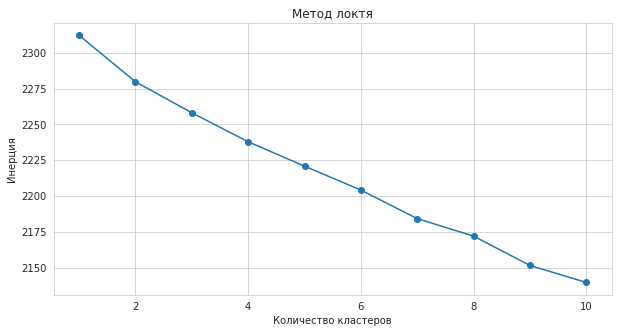

In [32]:
# значения инерции будут собираться в список
inertia_values = []
k_values = range(1, 11)  # переберу от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0) # задам параметры Kmeans
                                                  # где random state = 0, чтобы
                                                  # гаранитровать одинаковую инициализацию кластеров
    kmeans.fit(tfidf_matrix)
    inertia_values.append(kmeans.inertia_)

# Визуализация метода локтя
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.show()

Чем меньше инерция, тем лучше названия связаны друг с другом.  
На методе локтя надо заметить моменент, когда с увеличением количеством кластеров инерция начнет резко снижаться (это место и называют локтем). Как оптимальное количество кластеров берут именно такое значение, где инерция начинает резко убывать.  
Однако в данном случае заметного снижения инерции не видно, она снижается плавно.

##### Метод силуэта

Так как применение метода локтя не дало однозначного ответа по оптимальному количеству кластеров - воспользуюсь еще одним методо - методом силуэта.  
Он работает так: для каждой точки данных вычисляется силуэт, который представляет собой меру того, насколько точка похожа на свой собственный кластер по сравнению с соседними кластерами. Силуэт близок к 1, если точка хорошо согласуется с кластером, к которому она принадлежит, и близок к -1, если точка лучше подходит для другого кластера.  
Для каждого количества кластеров будет посчитан средний силуэт. И, соответственно, тот, который будет ближе всех к 1 является оптимальным.

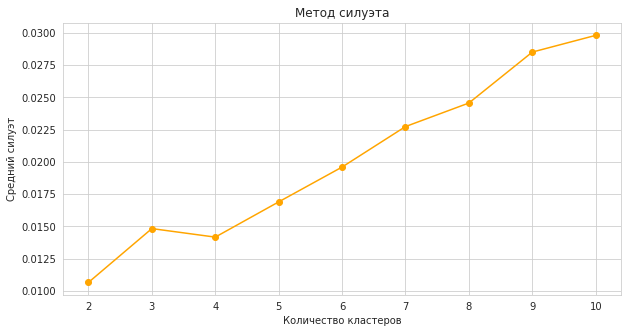

In [33]:
# диапозон с k_values и пустой список для значений силуэта
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(tfidf_matrix)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэт')
plt.title('Метод силуэта')
plt.show()

Как и с методом локтя на методе силуэта чем больше кластеров - тем больше связанность названий, и четкого пика на графике нет.  
Скорее всего это связано с тем, что в названиях мало повторяющихся слов.    

В дальнейшем придется вручную проверять наполнение кластеров, соответствие названий одному кластеру. Поэтому возьму число кластеров равное 6 и после при необходимости вручную добавлю еще категорий.

#### Кластеризация

Применю разделение названий на 6 кластеров.

In [34]:
# еще раз создам TF-IDF матрицу
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['product_lemma'])

clusters_num = 6
# создам объект kmeans
kmeans = KMeans(clusters_num)
# и применю его к tfidf матрице
kmeans.fit(tfidf_matrix)
print('Количество записей о кластерах', len(kmeans.labels_))

Количество записей о кластерах 2341


В `kmeans.labels_` сохранена информация о кластере, присвоенном каждому названию товара.  
Добавлю номер кластера в таблицу с наименованиям.

In [35]:
products['cluster'] = kmeans.labels_

Посмотрю количество названий в кластерах.

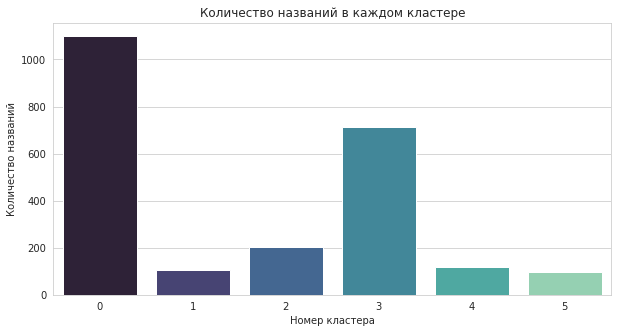

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=products.groupby('cluster', as_index=False)
                .agg({'product_lemma':'count'}),
           x='cluster', y='product_lemma', palette='mako')

plt.title('Количество названий в каждом кластере')
plt.xlabel('Номер кластера')
plt.ylabel('Количество названий');

В два из шести кластеров попадает наибольшее количество наименований.  
Чтобы было легче проводить ручную обработку - сокращу леммы по первых двух слов, их должно быть достаточно для определения категории.

In [37]:
products['short_name'] = products['product_lemma'].str.split().str[:2].str.join(' ')

In [38]:
print('Количество сокращенных названий:', products['short_name'].nunique())

Количество сокращенных названий: 959


Так и количество уникальных названий сократилось более чем вдвое.  
Обработаю названия из кластеров и присвою им названия категорий.

#### Присвоение категорий

Основываясь на кластеризации, я обработал категории, их итоговый перечень выглядит следующим образом:  
- Садоводство: товары, включащие в себя растения и рассады  
- Инвентарь: предметы быта, которые служат долгий срок (от года)  
- Интерьер: товары, связанные с декором и обустройством помещений  
- Детали: различные элементы, необходимые при сборке, мелкие детали  
- Расходники: потребительские, расходуемые товары быта (порошок, крем и прочие)  
- Инструменты: различные инструменты, которые служат в краткосрочном периоде  
- Кухня: кухонные принадлежности  
- Техника: приборы, работающие от электричества
- Хранение: коробки, ящики, стеллажи и прочие объекты для хранения

In [39]:
categories = {
    'Интерьер' : ['простынь','комнатный растение','муляж','коврик','искусственный','плед','ковёр','простыня','штора','ковровый',
 'декоративный','подушка','полотенце','светильник','маслёнка','халат','комод','одеяло','комплект','фоторамка','полотенце', 'халат',
 'нетканый','подвесной','наматрацник','наволочка','пододеяльник','двуспальный','покрывало','новогодний','подарочный','ваза','подставка цвет'],
    
    'Инвентарь' : ['тележка','сумка','сумка тележка','таз','стремянка','веник','швабра','подголовник','ведро','ножеточка',
 'ванна','корыто','шнур','урна','унитаз','совок','измерительный','линейка','овощечистка','держатель','лоток','ковш','скребок',
 'сетка','миска','ручка-скоба','пресс','лестница-стремянка','защитный','стремянка-табурет','вантуз','лестница','бак бельё','дозатор',
 'окномойка','урна-пепельница','насадка-моп','тряпкодержатель','отжим','бидон','карниз','сидение','сушилка','вешалка-сушилка', 'котёл'],
    
    'Детали' : ['прищепка','стяжка','крепёж','пружина','петлить','петля-стрела','пробка','кольцо','фал','бельевая',
 'фиксатор-шар','завёртка','ручка','уголок','основание','шпингалет'],
    
    'Инструменты' : ['щетка','ёрш','перчатка','щётка','подрукавник','свереть','сверло-фреза','гладильный','наматрасник',
 'наматрицник-чехол','насадка','губка','универсальный','ролик','шило','кисточка','щётка-смётка','мыльница','многофункциональный',
 'совка','орехоколка','штанга','скалка','ткань','сверло','шпагат','отделитель','покрытие','верёвка','решётка','запасный','тряпка',
 'мерный','подкладка','комплект ванная','настольный гладильный','рукав гладильный','покрытие гладильный'],
    
    'Расходники' : ['стиральный','крем','мыло','пена','паста','холодный','средство','бензин','антижир','сменный','косметь',
 'ароматизированный','бальзам','ополаскиватель','гипоаллергенный','увлажнять','мыло-скраб','концентрат','антинакипин','мешок',
 'отбеливатель','юкка','набор эмалировать','шприц','вакуумный пакет'],
    
    'Кухня' : ['сковорода','крышка','тарелка','вилка','ложка','нож','кружка','фужер','скатерть','кувшин','толкушка','противень',
 'tepмокружка','чайный','рыбочистка','тёрка','лопатка','салфетница','стакан','столовая','набор','кухонный','картофелемялка',
 'рассекатель','термостакан','термокружка','термос','фарфоровый','столовый','блюдце','бульонница','просеиватель','кастрюля',
 'насадка-отжим','венчик','сито','форма','тортница','блюдо','сотейник','сахарница','половник','салатник','сервировочный',
 'доска разделочный','разделочный','форма аlpenkok','салфетка','подставка нож','подставка яйцо'],
    
    'Техника' : ['чайник','миксер','утюг','овощеварка','измельчитель','фен дорожный','мантоварка','весы','кондиционер',
 'мантоварка-пароварка','пылесос','соковарка','пьезозажигалка','соковыжималка','кипятильник','термометр',
 'электроштопор'],
    
    'Хранение' : ['вешалка','крючок','корзина','банк','плечики','хранение','контейнер','ящик','короб','коробка','вешалка-плечики',
 'вешалка-стойка','кофр','жестяной','этажерка','ёмкость','вешалка-перекладина','модульный','хлебница','обувница-3','стеллаж',
 'корзинка','мусорный','подставка обувь','полка','ключница','складный','чехол'],
    
    'Садоводство' : ['герань','рассада','томат','флокс','растение','афеляндр','пеларгония','хризантема','бархатцы','морковь',
 'настурция','огурец','петуния','алиссума','гвоздик','годеция','календула','капуста','кореопсис','лапчатка','львиный','цинерария',
 'эшшольция','гиностемма','ель','кипарисовик','цветущий','кодонант','цикламен','антуриум','дендробиум','роза','аквилегия','базилик',
 'горох','земляника','незабудка','седума','тимьян','укроп','калла','декабрист','тюльпан','штангенциркуль','бакоп','калибрахоа',
 'овсянница','георгин','смолёвка','цинния','вербейник','колокольчик','котовник','эхинацея','ясколка','виола','лилейникнуть',
 'папоротник','платикодон','энотера','вербена','фуксия','гортензия','дыня','лобелия','пиретрум','вероника','клубника','маттиола',
 'арбуз','хост','гайлардия','монард','нивянник','рудбекия','барвинок','бегония','лаватер','анемон','буддлей','петрушка','табак',
 'клён','салат','кориандр','однолетний','зев','садовый','бальзамин','тагетис','целозия','лук','валериан','змееголовник',
 'любисток','сельдерей','шалфей','вигна','радермахер','хризолидокарпус','циперус','шеффлера','суккулента','эхеверие','эвкалипт',
 'адиантум','кампанула','калатея','нолин','хлорофитум','глоксиния','азалия','мирт','иссоп','сантолина','аспарагус','молодило',
 'фиалка','гербер','душица','мелисса','розмарин','альбук','крассула','артемизия','лаванда','мятый','каланхий','примула',
 'калоцефалус','каллуна','капсикума','мимоза','соланум','диффенбахий','фаленопсис','подсолнечник','пуансетие','аптения',
 'пуансеттие','скиммия','фиттония','алоэ','спатифиллум','фикус','гимнокалициум','кофе','эхинокактус','крокус','гипсофил',
 'эпипремнум','нефролепис','гиацинт','чабёр','ранункулус','лавр','цитрофортунелла','пеперомия','синнингий','гардения','девичий',
 'мускари','муррайя','баклажан','патиссон','джункус','драцена','фатсия','осина','сциндапсус','пряный','лантан','кабачок',
 'тыква','хамедорей','зверобой','мединилла','импатиенс','замиокулькас','амариллис','пахир','литопс','астр','бузульник','камнеломка',
 'солидаго','физостегия','бадан','лен']
             }

Создам функцию, которая будет возвращать название категории, основываясь на названии товара.

In [40]:
def categorize_product(product_name):
    """ 
    Возвращает категорию товара по его названию (при наличии ключевого слова категории в названии)
    """ 
    for category, names_list in categories.items():
        for name in names_list:
            if name in product_name:
                return category
    return 'Нет категории' # для случаев, где совпадения не обнаружено

Сначала применю функцию к `products`

In [41]:
products['category'] = products['short_name'].apply(categorize_product)

Проверю, есть ли товары, которым не присвоилась категория.

In [42]:
print('Количество товаров, для которых нет категории:',
     len(products.query('category == "Нет категории"')))

Количество товаров, для которых нет категории: 0


Отлично, таких товаров нет. Тогда перенесу категории товаров в основной набор данных `orders`

In [43]:
orders = orders.merge(products[['product', 'category']], on='product', how='left')

In [44]:
orders.to_csv (r'C:\Users\ilya.zalygin\Desktop\here\orders.csv', index= False)

### Вывод предобработки

Данные были очищены от заказов, id которых дублировался другим пользователям.  
Также были удалены дубликаты заказов по дате и тестовый заказ.  
Из 7474 записей было удалено 1900, и осталось 5574.  

Товарам были присовены категории, основываясь на кластеризации наименований методо K-means.  
Было выделено 9 категорий:
- Садоводство: товары, включащие в себя растения и рассады
- Инвентарь: предметы быта, которые служат долгий срок (от года)
- Интерьер: товары, связанные с декором и обустройством помещений
- Детали: различные элементы, необходимые при сборке, мелкие детали
- Расходники: потребительские, расходуемые товары быта (порошок, крем и прочие)
- Инструменты: различные инструменты, которые служат в краткосрочном периоде
- Кухня: кухонные принадлежности
- Техника: приборы, работающие от электричества
- Хранение: коробки, ящики, стеллажи и прочие объекты для хранения

## Исследовательский анализ

### Общий обзор данных и анализ магазина

#### Временной период данных

Сначала изучу период, за который собраны данные.  
Построю график, который отразит месяц и количество записей в нем.

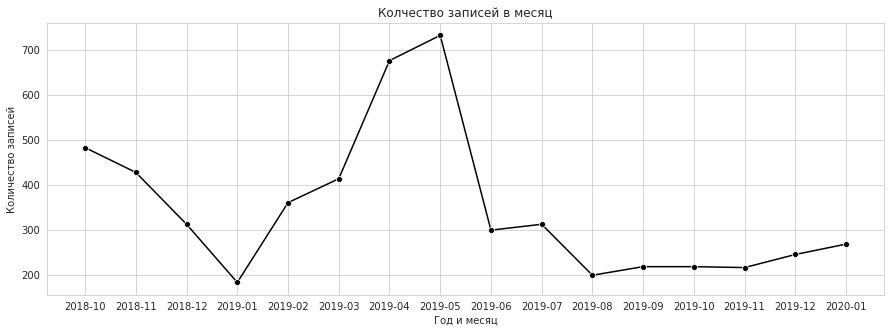

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=orders.groupby('month').agg({'timestamp':'count'}),
             x='month', y='timestamp', color='black', marker='o')
plt.title('Колчество записей в месяц')
plt.xlabel('Год и месяц')
plt.ylabel('Количество записей');

Я располагаю данным от октября 2018 до января 2020 года.  
График имеет выраженный пик и спад.
В январе 2019 - самое низкое количество записей (184), в мае самое большое количество записей (720).  
Возможно, это связано с сезонностью бизнеса, который в том числе продает растения и рассаду, которая пользуется повышенным спросом к лету.

#### Динамика выручки

По логике бизнеса выручка скорее должна иметь схожую динамику с количеством записей, ведь каждая запись - это информация о товаре из заказа, а чем больше заказов - тем выше выручка. Посмотрю на график выручки по месяцам и на график количества заказов.

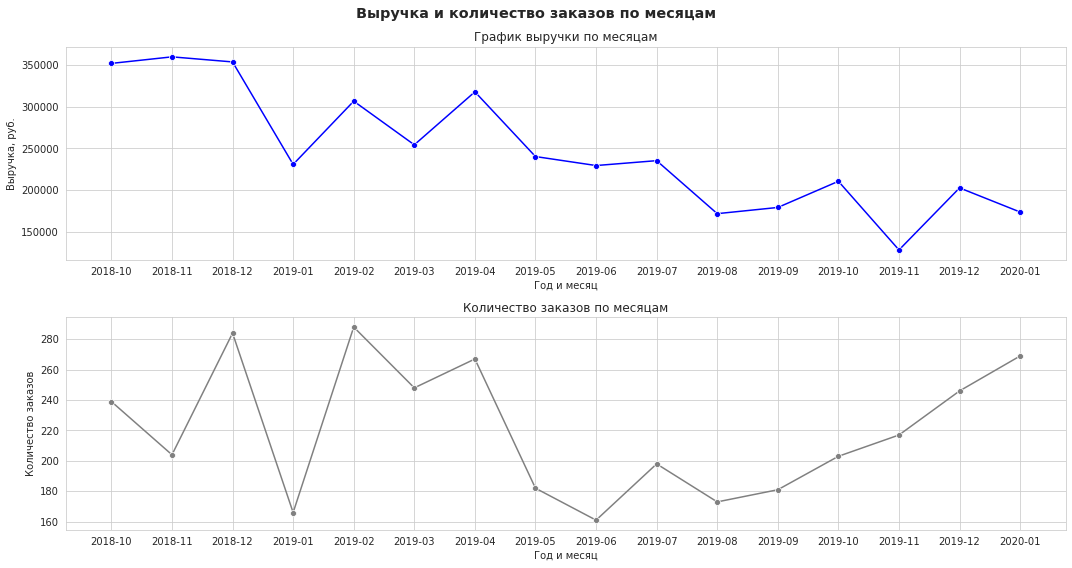

In [45]:
fig, axs = plt.subplots(nrows=2 , ncols=1, figsize=(15, 8))
fig.suptitle('Выручка и количество заказов по месяцам', size='x-large', fontweight='semibold')

# график выручки
sns.lineplot(data=orders.groupby('month').agg({'revenue':'sum'}),
             x='month', y='revenue', marker='o', color='blue', ax=axs[0])
axs[0].set_title('График выручки по месяцам')
axs[0].set_xlabel('Год и месяц')
axs[0].set_ylabel('Выручка, руб.')

# график количества заказов
sns.lineplot(data=orders.groupby('month').agg({'order_id':'nunique'}),
             x='month', y='order_id', marker='o', color='grey', ax=axs[1])
axs[1].set_title('Количество заказов по месяцам')
axs[1].set_xlabel('Год и месяц')
axs[1].set_ylabel('Количество заказов')
plt.tight_layout();

На графике выручки видно совпадение спада выручки со спадом количества заказов в январе 2019 и со спадом с августа.  
Выручка колеблется от 150 000 до 350 000. Это ощутимый разброс, максимальное значение больше минимального в 2,3 раза (или на 133%).  
Количество заказов достигает значений от 160 до 280, здесь разброс уже не так велик, максимальное значение больше минимального в 1,75 раз (или на 75%).  
Ожидаемого пика выручки в мае нет. Ровно как и большого количества заказов.  
Прежде чем делать предположения - дополнительно посмотрю на средний чек по месяцам.

#### Динамика среднего чека по месяцам

Чтобы улучшить понимание бизнеса - посмотрю на средний чек в динамике по месяцам.

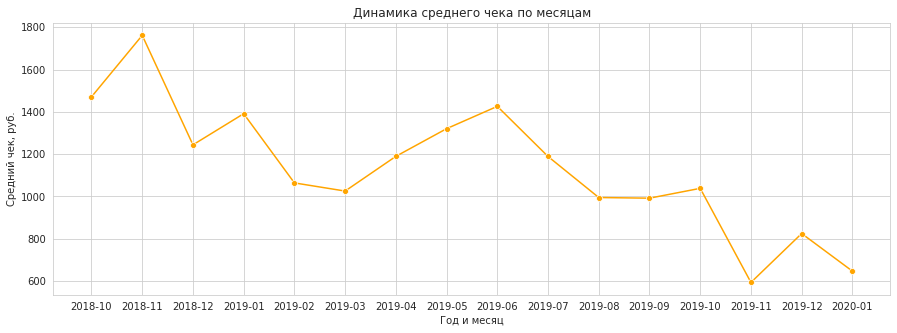

In [46]:
# для этого создам датафрейм со средним чеком
avg_bill_per_month = (orders.groupby('month', as_index=False)
                      .agg({'revenue':'sum'}).merge(
                      orders.groupby('month', as_index=False)
                      .agg({'order_id':'nunique'}), on='month'))
avg_bill_per_month['avg_bill'] = avg_bill_per_month['revenue'] / avg_bill_per_month['order_id']

# и построю график
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=avg_bill_per_month, x='month', y='avg_bill',
             color='orange', marker='o')
plt.title('Динамика среднего чека по месяцам')
plt.xlabel('Год и месяц')
plt.ylabel('Средний чек, руб.');

Теперь видно, что средний чек с апреля по июнь все же растет. К июню на 40% по сравнению с мартом.  
Средний чек значительно снизился к концу наблюдаемого периода - почти в два раза по сравнению с летом 2019.  
Динамика среднего чека наводит на мысль, компания недополучает потенциальную выручку в летний период.  
Так как средний чек в это время высокий, но количество заказов и, соответственно, выручка - нет.  
Это может быть связано с разными фаткорами: с недостатком товаров в спросе или со слабой маркетинговой активностью, но с имеющимися данными эти гипотезы проверить не удастся.

#### Активность уникальных пользователей

Изучу активность пользователей в магазине.  
Посмотрю на количество уникальных пользователей, которые совершают заказы по месяцам, а также посмотрю на количество новых приходящих пользователей по месяцам. Поскольку важно понимать, привлекает ли магазин новых покупателей, или большинство заказов совершают одни и те же клиенты.

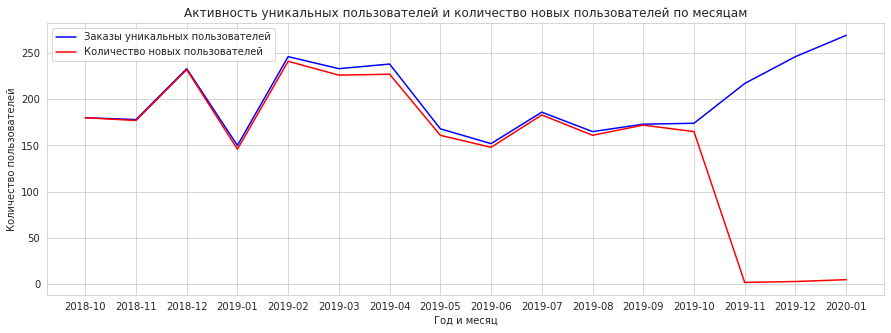

In [47]:
plt.figure(figsize=(15,5))

# количество ункальных пользователей, совершивших заказ
sns.lineplot(data=orders.groupby('month').agg({'customer_id':'nunique'}),
             x='month', y='customer_id', color='blue', label='Заказы уникальных пользователей')
# количество новых пользователей
sns.lineplot(data=orders[['month','customer_id']].drop_duplicates(subset=['customer_id'])
             .groupby('month').agg({'customer_id':'nunique'}),
             x='month', y='customer_id', color='red', label='Количество новых пользователей')

plt.legend()

plt.title('Активность уникальных пользователей и количество новых пользователей по месяцам')
plt.xlabel('Год и месяц')
plt.ylabel('Количество пользователей');

С октября 2018 по октябрь 2019 почти все заказы совершали новые пользователи, а вот с ноября 2019 новые пользователи перестали приходить, и заказы совершали те же клиенты, что обращались к услугам магазина ранее.  
Бизнесу стоит обратить внимание на такую особенность и усилить маркетинговые меры по привлечению новых клиентов.

### Изучение покупателей

In [48]:
print('Всего клиентов:', orders['customer_id'].nunique())

Всего клиентов: 2429


Всего в наборе данных присутствует 2429 уникальных покупателей.  
Изучу их подробнее. Начну с исследования количества заказов на пользователя.

#### Количество заказов на пользователя

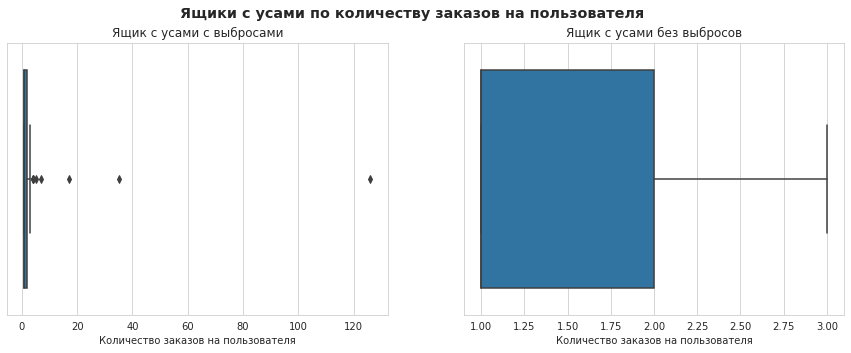

In [49]:
fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
fig.suptitle('Ящики с усами по количеству заказов на пользователя',
             size='x-large', fontweight='semibold')

sns.boxplot(x=orders.groupby('customer_id').agg({'order_id':'nunique'})['order_id'],
           ax=axs[0])
axs[0].set_title('Ящик с усами с выбросами')
axs[0].set_xlabel('Количество заказов на пользователя')

sns.boxplot(x=orders.groupby('customer_id').agg({'order_id':'nunique'})['order_id'],
           showfliers=False, ax=axs[1])
axs[1].set_title('Ящик с усами без выбросов')
axs[1].set_xlabel('Количество заказов на пользователя');

Также применю функцию, опсиывающую данные

In [50]:
orders.groupby('customer_id').agg({'order_id':'nunique'}).describe()

,order_id
count,2429.000000
mean,1.449156
std,2.689519
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,126.000000


In [51]:
iqr_orders = (orders.groupby('customer_id').agg({'order_id':'nunique'}).quantile(0.75)[0] -
              orders.groupby('customer_id').agg({'order_id':'nunique'}).quantile(0.25)[0])
upper_bound = (orders.groupby('customer_id').agg({'order_id':'nunique'}).quantile(0.75)[0] +
               1.5*iqr_orders)
print('Общее количество выбросов:',
      orders.groupby('customer_id')
      .agg({'order_id':'nunique'})
      .query('order_id > @upper_bound').count()[0])

Общее количество выбросов: 8


По графику ящика с усами видно, что большинство пользователей совершает не более 3 заказов за все время.  
Это важная деталь в специфике магазина. За год и три месяца только 8 клиентов совершили более трех заказов, один из них сделал 126 заказов, что является крупнейшим выбросом.

#### Повторные покупки

Исследую повторные покупки в данных.  
Сначала найду долю пользователей, которые совершали повторные покупки.

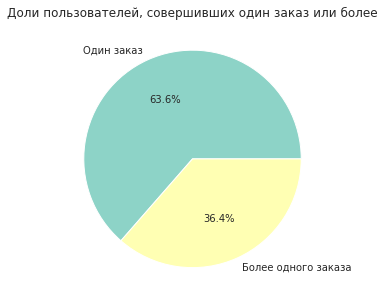

In [52]:
one_order = (orders.groupby('customer_id').agg({'order_id':'nunique'})
             .query('order_id == 1').count()[0])
more_than_one_order = (orders.groupby('customer_id').agg({'order_id':'nunique'})
                       .query('order_id > 1').count()[0])

fig, ax = plt.subplots(figsize=(5,5))
plt.pie([one_order, more_than_one_order], labels=['Один заказ', 'Более одного заказа'],
        autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Доли пользователей, совершивших один заказ или более');

Только 36% пользователей совершают более одного заказа.  
И стоит учитывать, что большинство пользователей совершает не более 3 заказов. Поэтому можно заключить, что специфика бизнеса - это в основном работа с новыми пользователями, которые совершают один заказ.

#### Перерыв до повторного заказа

Изучу пользователей, которые совершили более одного заказа. Посмотрю, через какое время они делают повторный заказ.

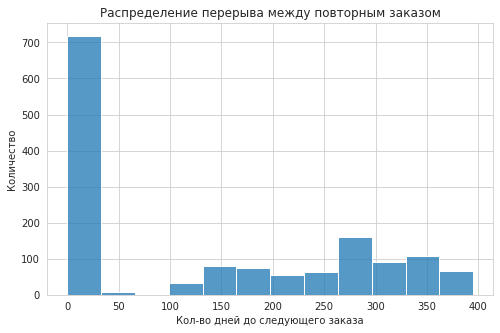

In [53]:
repeated_orders_users = (orders.groupby('customer_id').agg({'order_id':'nunique'})
                         .query('order_id > 1').index.tolist())
# отберу тех пользователей, которые совершали повторый заказ
repeated_orders = (orders.query('customer_id in @repeated_orders_users')
                   [['customer_id','order_id','date']]
                   .sort_values(['customer_id','date']))
# и найду разницу перерыва в днях 
repeated_orders['timediff'] = repeated_orders.groupby('customer_id')['date'].diff().dt.days
# удалю пустые значения, так как это первый заказ
repeated_orders = repeated_orders.dropna()
# и посмотрю на распределение временного перерыва между заказами
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(repeated_orders['timediff'])
plt.title('Распределение перерыва между повторным заказом')
plt.xlabel('Кол-во дней до следующего заказа')
plt.ylabel('Количество');

In [54]:
print('Процент пользователей которые возращаются через 100 и более дней:',
      (round(repeated_orders.query('timediff > 99')['customer_id'].nunique()
             / repeated_orders['customer_id'].nunique(), 2)*100),'%')

Процент пользователей которые возращаются через 100 и более дней: 83.0 %


Много повторных заказов оформляется в тот же день, что и первый.  
Но тем не менее - много тех пользователей, которые возвращаются через большой промежуток времени - от 100 до 400 дней.  
Среди категорий товаров есть бытовые, расходующиеся товары, но, видимо, большинство покупателей приобретают другие категории товаров, раз крайне мало пользователей, которые совершили заказ через 50-100 дней.  
Специфика товарного ряда обуславливает существование долгих перерывов перед повторным заказом.

#### Выручка с заказов

Посмотрю на распределение чека заказа за все время.  
Построю две гистограммы - для всех сумм заказа и отдельную с ограничением до верхнего межквартильного размаха суммы.

Верхняя граница суммы: 2810


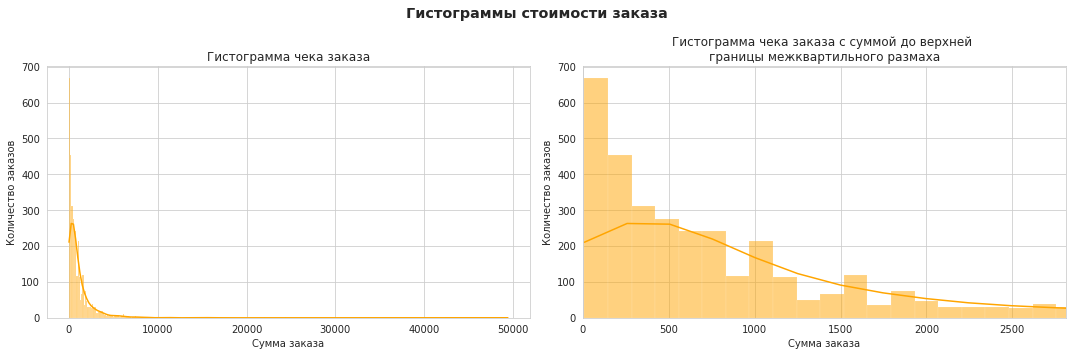

In [55]:
upper_revenue = (orders.groupby('order_id').agg({'revenue':'sum'})['revenue'].quantile(0.75)
                 + 1.5*(orders.groupby('order_id').agg({'revenue':'sum'})['revenue'].quantile(0.75)
                 - orders.groupby('order_id').agg({'revenue':'sum'})['revenue'].quantile(0.25)))

fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
fig.suptitle('Гистограммы стоимости заказа',
             size='x-large', fontweight='semibold')

sns.histplot(orders.groupby('order_id').agg({'revenue':'sum'})['revenue'],
             kde=True, color='orange', ax=axs[0])
axs[0].set_title('Гистограмма чека заказа')
axs[0].set_xlabel('Сумма заказа')
axs[0].set_ylabel('Количество заказов')

sns.histplot(orders.groupby('order_id').agg({'revenue':'sum'})['revenue'],
             kde=True, color='orange', ax=axs[1])
axs[1].set_xlim(0,upper_revenue)
axs[1].set_title('Гистограмма чека заказа с суммой до верхней '
                 '\n' 'границы межквартильного размаха')
axs[1].set_xlabel('Сумма заказа')
axs[1].set_ylabel('Количество заказов')
plt.tight_layout()
print('Верхняя граница суммы:', round(upper_revenue))

Несмотря на то, что в магазине продаются и дорогостоящие товары - в основном сумма заказа ограничена до 2810 рублей.  
Больше всего заказов вовсе в диапазоне до 250 рублей.  
Есть и особо крупные заказы с суммой от 15 до 49 тысяч, но таких единицы.

### Исследование категорий

Изучу сформированные раннее категории. Напомню, что товары были поделены на 9 категорий, основываясь на названии и назначении.  
Посмотрю на популярность категорий, сколько раз покупались товары в каждой категории.

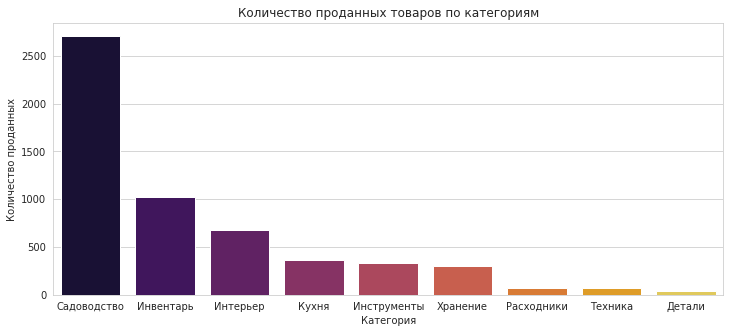

In [56]:
fig, ax = plt.subplots(figsize=(12,5))

fig = sns.barplot(data=orders.groupby('category', as_index=False).agg({'product':'count'})
                  .sort_values('product', ascending=False),
                  x='category', y='product', palette='inferno')
plt.title('Количество проданных товаров по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество проданных');

Самая продаваемая категория - *Садоводство*. Товары из этой категории продались более 2500 раз.  
Категория *Инвентарь* около 1000 раз, *Интерьер* около 650.  
Другие категории менее популярны.  
Посмотрю на цены товаров каждой категории.

#### Цены товаров по категориям

Визуализирую цены на товары по категориям через ящик с усами.

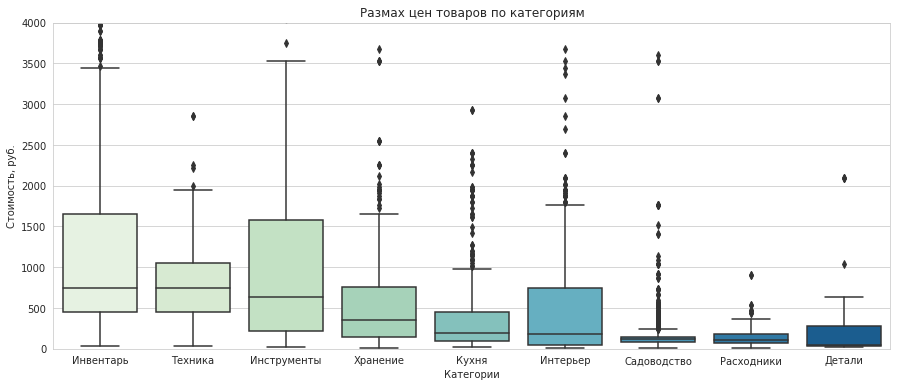

In [57]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxplot(data=orders, y='price', x='category', palette='GnBu',
            order=orders.groupby('category').agg({'price':'median'})
                  .sort_values('price', ascending=False).index.tolist())
plt.ylim(0, 4000)
plt.title('Размах цен товаров по категориям')
plt.xlabel('Категории')
plt.ylabel('Стоимость, руб.');

In [58]:
(pd.DataFrame(orders.groupby('category').agg({'price':'median'})
 .sort_values('price', ascending=False))
 .rename(columns={'price':'Медианная стоимость товара'})
 .style.background_gradient('GnBu')
 .format({'Медианная стоимость товара':'{0:.0f}'}))

,Медианная стоимость товара
category,
Инвентарь,749
Техника,749
Инструменты,637
Хранение,352
Кухня,194
Интерьер,179
Садоводство,120
Расходники,104
Детали,48


В таблице представлены товарные категории, отсортированные по медианной стоимости.  
Товары из категории *Инвентарь* - лидеры по медианной цене товара, разброс цен в этой категории доходит до 3500 рублей.  
*Техника* и *Инструменты* - входят в топ-3 по медианной стоимости товаров.
Самые дешевые товары - из категорий *Садоводство*, *Расходники* и *Детали*.  
Больше всего выбросов по цене в категориях *Инвентарь* и *Интерьер*.  

Посмотрю, насколько прибыльная каждая из групп товаров.

#### Прибыльность товарных категорий

Построю график выручки для категорий по месяцам.

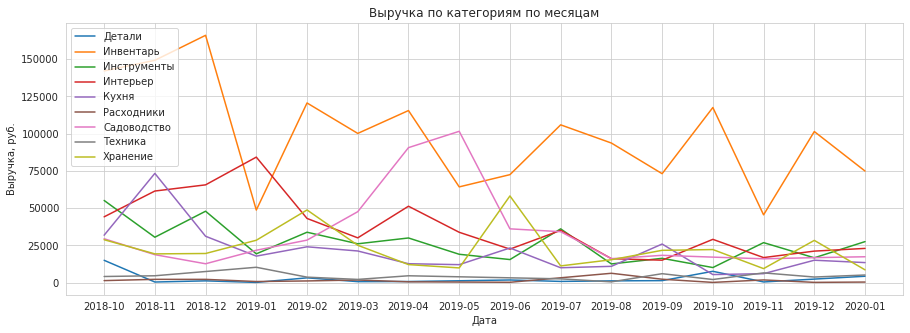

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=orders.groupby(['month', 'category']).agg({'revenue':'sum'}),
             x='month', y='revenue', hue='category')
plt.legend(loc='upper left')
plt.title('Выручка по категориям по месяцам')
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.');

Вспомогательно выведу таблицу суммы накопленной выручки по категориям за все время.

In [61]:
(pd.DataFrame(orders.groupby('category').agg({'revenue':'sum'})
              .sort_values('revenue', ascending=False))
 .style.background_gradient('GnBu')
 .format({'revenue':'{0:.0f}'}))

,revenue
category,
Инвентарь,1590841
Интерьер,591648
Садоводство,522044
Инструменты,422502
Хранение,366030
Кухня,333154
Техника,62544
Детали,37848
Расходники,20291


Наибольшую выручку приносят товары категории *Инвентарь* с существенным отрывом от других.  
Неудивительно, ведь это самая дорогая категория товаров.  
Другие лидеры - *Интерьер* и *Садоводство*.  
На графике выручки по месяцам заметно, что у *Садоводства* есть существенный рост с мая по июнь, связанный с сезонностью категории. Товары других категорий на первый взгляд выраженной сезонности не имеют.

#### Сезонность категорий

Чтобы оценить сезонность категорий товаров - посмотрю на тепловую карту суммы продаж от месяца к месяцу.

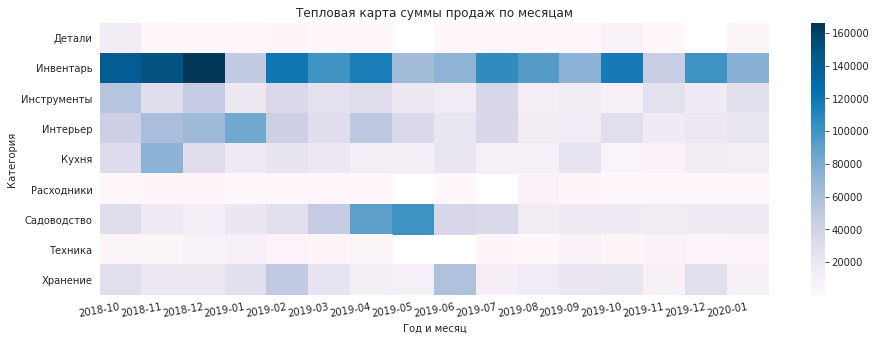

In [62]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(orders.pivot_table(index='category', columns='month', values='revenue', aggfunc='sum'),
            cmap='PuBu')
plt.xticks(rotation=10, ha='right')
plt.title('Тепловая карта суммы продаж по месяцам')
plt.xlabel('Год и месяц')
plt.ylabel('Категория');

Среди заметных изменений по сезонности можно отметить следующее:  
1 Товары категории *Садоводство* ожидаемо сильно растут с апреля по май,  
2 В 2018 товары *Интерьера* выросли в ноябре, но подобной динамики не наблюдается в 2019 году,  
Других значимых изменений среди продаж категорий в связи со сменой сезона не наблюдается.

### Вывод исследовательского анализа

**Общий обзор данных**  
Данные собраны за период от октября 2018 до января 2020 года.  
Выручка за это время колеблется от 150 до 300 тыс. в месяц, а количество заказов от 160 до 280 в месяц.  
За три месяца 2018 года выручка достигала самых высоких значений в районе 350 тыс. руб., затем резко снизилась до 240 тыс. в январе 2019. За 2019 год самая высокая выручка была в апреле и достигла около 315 тыс. К концу 2019 выручка снижалась и достигла минимального значения в 130 тыс. в ноябре.  
Количество заказов в основном подчинялось динамике выручки и снижалось к сентябрю 2019, после чего начало показывать устойчивые темпы роста.  

При этом за 2019 год средний чек был достиг самого высокого значения в июне месяце и составил 1400 руб., после чего начал снижаться.  
Средний чек изменялся в диапазоне от 600 руб. (ноябрь 2019) до 1700 руб. (ноябрь 2018).  
С октября 2018 по октябрь 2019 почти все заказы совершали новые пользователи, а с ноября 2019 новые пользователи перестали приходить, и заказы совершали те же клиенты, что обращались за услугами магазина ранее.  

**Изучение покупателей**  
Всего в наборе данных собрана информация о 2429 клиентах.  

Большинство пользователей совершило не более 3 заказов за исследуемый период.  
64% клиентов совершило лишь одну покупку, 34% более одной.  
Треть повторных заказов было совершено в тот же день, что и первый. Никто не совершает повторный заказ через 50-100 дней, но покупатели возвращаются в течение 101-390 дней.  

Заказы в основном ограничваются суммой до 2810 рублей.  

**Изучение категорий**  
Самая продаваемая категория - *Садоводство*. Товары из этой категории продались более 2500 раз. Категории *Инвентарь* около 1000 раз, *Интерьер* около 650.  
Самые непопулярные категории - *Расходники*, *Техника* и *Детали*.  

Самые дорогие категории товаров - *Инвентарь* (медианная цена 749 руб.), *Техника* (749), *Инструменты* (637).  
Самые дешевые - *Садоводство* (120), *Расходники* (104) и *Детали* (48)  

Самая высокая кумулятивная выручка - у товаров из категории *Инвентарь* (1 590 841 руб.). Следом за ним - *Интерьер* (591 тыс.), *Садоводство* (522 тыс.)  
Самая низкая - у *Техники* (62 тыс.), *Деталей* (37 тыс.) и у *Расходников* (20 тыс.)  
Кумулятивная выручка заметно растет у *Садоводства* в период с мая по июнь, другие категории не имеют выраженних пиков роста относительно помесячных значений.  
Сезонность также выражена только у этой категории товаров.

## Сегментация пользователей

В целях сегментации я попробую применить несколько подходов, после чего выберу один и буду формулировать по нему рекомендации.

Определю функцию, с которой буду сравнивать формирующеся сегменты.

In [63]:
def visualise_segments(data, text, fliers=False):
    """
    Функция создает два boxplot'а по среднему чеку и количеству заказов в сегменте.  
    Boxplot по умолчанию создается без выбросов.
    """
    colors = sns.color_palette('GnBu', n_colors=len(data['segm'].unique()))
    my_palette = dict(zip(data['segm'].unique(), colors))
    fig, axs = plt.subplots(nrows=2 , ncols=1, figsize=(15, 8))
    fig.suptitle('Диаграммы размаха стоимости заказа и количества заказов для сегментации по ' + text,
                  size='x-large', fontweight='semibold')
    sns.boxplot(data=data, x='segm', y='revenue', palette=my_palette,
                order=data.groupby('segm').agg({'revenue':'median'})
                      .sort_values('revenue', ascending=False).index.tolist(),
                ax=axs[0], showfliers=fliers)
    axs[0].set_title('Величина чека для сегментации по ' + text)
    axs[0].set_xlabel('Сегмент')
    axs[0].set_ylabel('Сумма чека, руб.')
    sns.boxplot(data=data, x='segm', y='order_id', palette=my_palette,
                order=data.groupby('segm').agg({'order_id':'median'})
                      .sort_values('order_id', ascending=False).index.tolist(),
                ax=axs[1], showfliers=fliers)
    axs[1].set_title('Кол-во заказов на пользователя для сегментации по ' + text)
    axs[1].set_xlabel('Сегмент')
    axs[1].set_ylabel('Количество заказов')
    plt.tight_layout()

### Сегментация по чеку

Для каждого пользователя найду величину чека. Средним он будет для пользователей, совершивших более 1 заказа.  
Также добавлю столбец с количеством заказов на пользователя, чтобы сравнить их по этому показателю.

In [64]:
segm_by_check = (orders.groupby(['customer_id','order_id'], as_index=False)
                 .agg({'revenue':'sum', 'order_id':'nunique'})
                 .groupby('customer_id', as_index=False)
                 .agg({'revenue':'mean', 'order_id':'sum'}))

Поделю пользователей на 3 категории чека `низкий`, `средний`, `высокий`.  
<br> Применю для этого метод *qcut*, который основывается при разделении выборки на квартилях.

In [65]:
segm_by_check['segm'] = pd.qcut(segm_by_check['revenue'], q=3, labels=False)

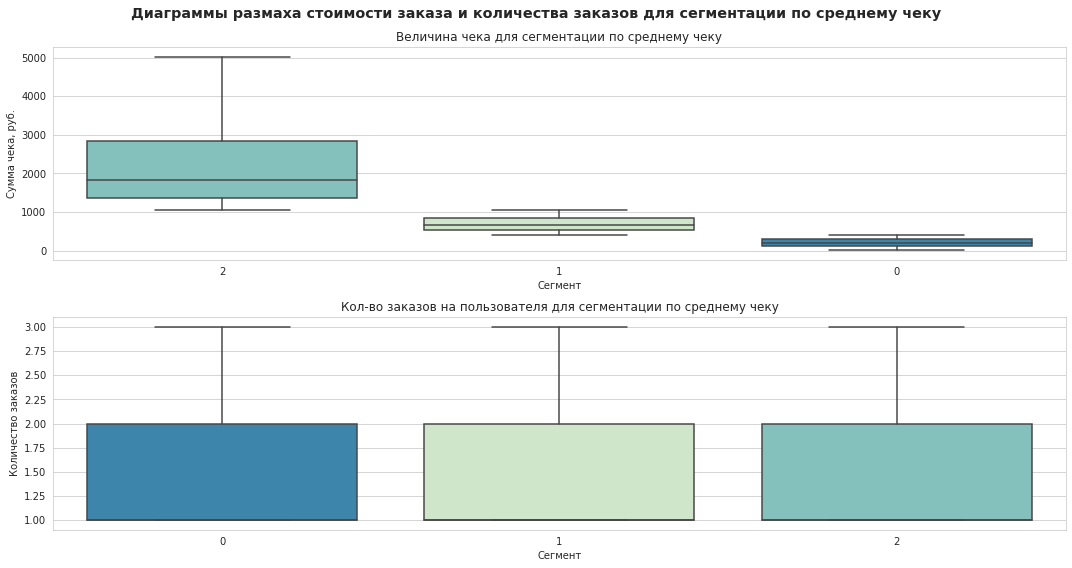

In [66]:
visualise_segments(segm_by_check, 'среднему чеку')

Сегменты хорошо разделились по среднему чеку, где 0 сегмент - с низким чеком, 1 со средним и 3 с высоким.  
А вот нормальные границы количества заказов везде одинаковые.  
Посмотрю характеристики сегментов в таблице, дополнительно посмотрю, какие максимальные количества заказов попали в каждую группу.

In [67]:
(pd.DataFrame(segm_by_check.groupby('segm').
 agg({'customer_id':'nunique', 'revenue':'median', 'order_id':'max'}))
 .rename(columns={'customer_id':'Кол-во пользователей',
                  'revenue':'Медиан. чек',
                  'order_id':'Макс. кол-во заказов'})
 .style.background_gradient('GnBu')
 .format({'Медиан. чек':'{0:.0f}'}))

,Кол-во пользователей,Медиан. чек,Макс. кол-во заказов
segm,,,
0,810,208,4
1,821,656,7
2,798,1821,126


Количество пользователей в каждом сегменте почти одинаковое, и максимальное количество заказов тем больше, чем выше медианный средний чек в группе. Но не стоит забывать, что количество заказов больше трех - это статистический выброс и на самом деле по этому критерию с трудом можно определять разницу в сегментах.

### Сегментация по количеству заказов

Попробую также другой способ сегментации - по количеству заказов.  
Также создам отдельный датафрейм, где найду количество заказов и средний чек, который понадобится для дальнейшего анализа.  

Выберу количество сегментов снова равное трем, поскольку, как выяснилось ранее, больше 3 заказов в принципе делают очень редко.  
И создание больше трех сегментов будет избыточным.

In [68]:
segm_by_orders = (orders.groupby(['customer_id','order_id'], as_index=False)
                  .agg({'revenue':'sum', 'order_id':'nunique'})
                  .groupby('customer_id', as_index=False)
                  .agg({'revenue':'mean', 'order_id':'sum'}))
# сегментирую пользователей по количеству заказов
segm_by_orders['segm'] = pd.qcut(segm_by_orders['order_id'], q=3, labels=False, duplicates='drop')

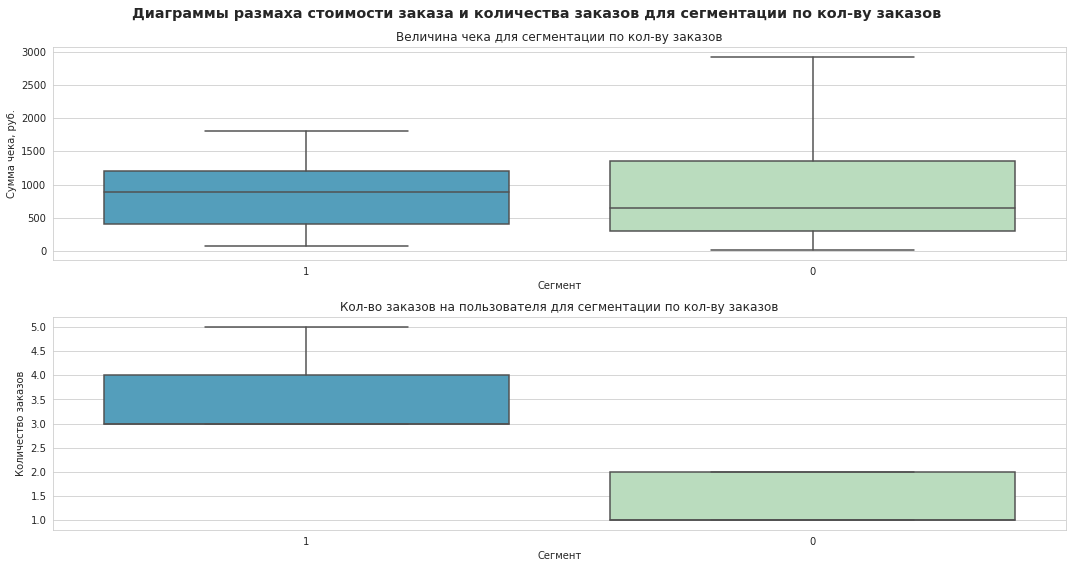

In [69]:
visualise_segments(segm_by_orders, 'кол-ву заказов')

Из-за того, что в выборке крайне мало пользователей, которые совершали много заказов метод *qcut* даже не выделил третьего сегмента.  
В 0 сегмент вошли пользователи, которые делали от 1 до 2 заказов. А в 1 - те, кто делали от 3 и более.  
При этом значимой разницы в их среднем чеке не наблюдается даже визуально.  

Дополнительно проверю, есть ли разница в их средних чеках, применив тест Манна-Уитни, так как средний чек имеет распределение, отличное от нормального, как было видно на этапе исследовательского анализа.

In [70]:
print('p-value гипотезы о равенстве средних чеков двух сегментов',
      st.mannwhitneyu(segm_by_orders.query('segm == 0')['revenue'],
                      segm_by_orders.query('segm == 1')['revenue']).pvalue)

p-value гипотезы о равенстве средних чеков двух сегментов 0.5881515786292091


P-value равно около 0.6, что значит, что с вероятностью в ~60% различия в выборках обусловлены случайностью.  
Разницы в средних чеках сегментов по количеству заказов действительно нет.

In [71]:
segm_by_orders.groupby('segm').agg({'customer_id':'count'})

,customer_id
segm,
0,2401
1,28


Кроме того, в сегмент с количеством заказов от 3 вошли всего 28 покупателей, так что статистическую проверку в принципе можно было не применять, так как не стоит полагаться на такую маленькую выборку.

### Сегментация по категориям товаров

Сегмент пользователя будет совпадать с той категорией товаров, на которую он потратил больше всего денег.  

Найду сумму того, сколько каждый пользователь потратил в определенной категории.  
Затем отсоритрую данные по пользователям, чтобы для каждого из них первой строкой стояла категория с самой большой суммой.  
И оставлю только эту строку. Категория и станет сегментом пользователя.

In [74]:
users_categories = (orders.groupby(['customer_id','category'], as_index=False)
                     .agg({'revenue':'sum'})
                     .sort_values(['customer_id','revenue','category'],
                                  ascending=[True, False, False]))

users_categories = users_categories.drop_duplicates('customer_id', keep='first')
print('Количество пользователей в изначальном датасете:', orders.customer_id.nunique(),
      '\n' 'Количество категоризированных пользователей:', users_categories.customer_id.nunique())

Количество пользователей в изначальном датасете: 2429 
Количество категоризированных пользователей: 2429


Теперь все пользователи категоризованы. И можно приступить к их анализу.

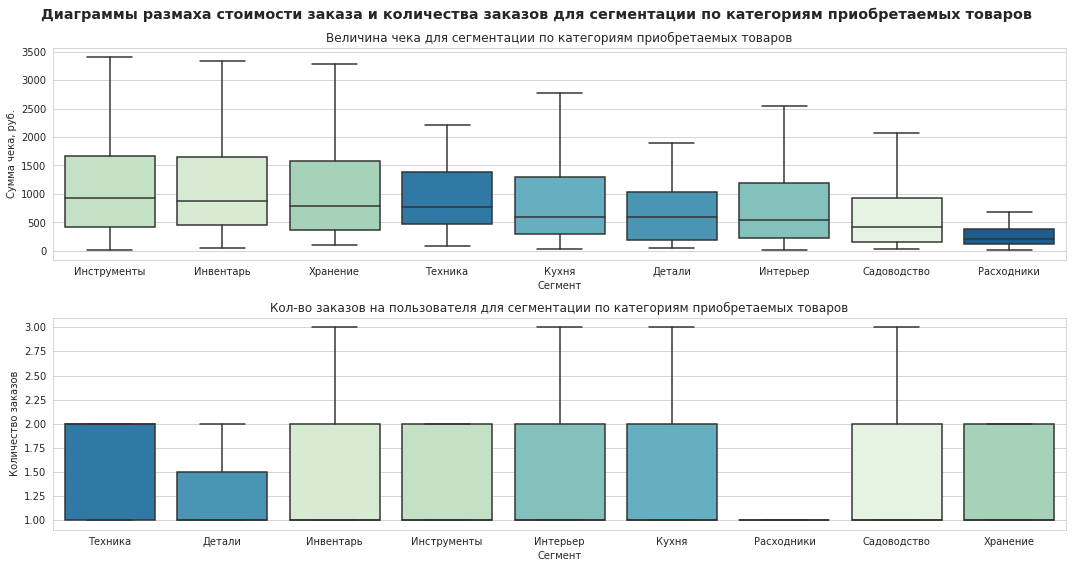

In [75]:
segm_by_category = (orders.groupby(['customer_id','order_id'], as_index=False)
                   .agg({'revenue':'sum', 'order_id':'nunique'})
                   .groupby('customer_id', as_index=False)
                   .agg({'revenue':'mean', 'order_id':'sum'}))
segm_by_category = segm_by_category.merge(users_categories[['customer_id','category']],
                                          on='customer_id', how='left'
                                         ).rename(columns={'category':'segm'})

visualise_segments(segm_by_category, 'категориям приобретаемых товаров')

Медианный чек в сегментах колеблется от 590 до 920 рублей, где самый высокий у пользователей, предпочитающих категорию *Инструменты*, *Инвентарь* и *Хранение*.  
Ниже всех средний чек у пользователей, которые в основном пользуются магазином для покупки расходующихся бытовых товаров и покупателей растений.  
Чаще других заказы делают пользователи, интересующиеся такими товарными категориями как *Инвентарь*, *Интерьер*, *Кухня* и *Садоводство*.  

Вспомогательно выведу таблицу по категориям с характеристиками.

In [76]:
pd.DataFrame(segm_by_category.groupby('segm').agg({'customer_id':'nunique',
                                                   'revenue':'median',
                                                   'order_id':'median'})
             .sort_values('customer_id', ascending=False)
             .rename(columns={'customer_id':'Кол-во клиентов',
                              'revenue':'Медианный чек',
                              'order_id':'Мед. кол-во заказов'})
            ).style.background_gradient('GnBu').format({'Медианный чек':
                                                        '{0:.1f}'})

,Кол-во клиентов,Медианный чек,Мед. кол-во заказов
segm,,,
Инвентарь,747,876.5,1
Садоводство,567,412.0,1
Интерьер,397,550.5,1
Инструменты,229,929.0,1
Кухня,206,594.0,1
Хранение,178,791.0,1
Техника,43,779.5,2
Расходники,35,208.0,1
Детали,27,592.0,1


Больше всего клиентов относятся к сегменту *Инвентарь*, *Садоводство* и *Интерьер*.  
Это важные клиенты, которые делают наибольшую выручку, так как это в том числе категории товаров, которые принесли наибольшую выручку за период, если вспомнить график кумулятивной выручки по категориям товаров.  
Хотя у клиентов из категории *Садоводство* и низкий средний чек, они все равно являются важной опорой бизнеса.  
Клиенты всех сегментов в основном сделали один заказ за исследуемый период.

### Выбор метода сегментации

Я попробовал три способа сегментации пользователей: по среднему чеку, по количеству заказов и по товарной категории.  
Разберу каждый метод сегментации и выберу один.  

**Метод сегментации по среднему чеку**  
В рамках этого метода пользователи были поделены на пользователей с низким, средним и высоким чеком.  
К низким относятся те, у кого средний чек до 405 руб.  
К средним те, у кого средний чек от 405 до 1049 руб.  
К высоким те, у кого средний чек от 1050 руб.  
В каждом из сегментов примерно по 800 клиентов.  

Я считаю, что этот метод сегментации не подходит бизнесу, поскольку всего 36% пользователей делает больше одного заказа.  
Тогда в отношении 64% пользователей будет сформировано мнение, основываясь лишь на одном заказе.  
Но случайный заказ не определяет ни достатка клиента, ни его поведения.

**Метод сегментации по количеству заказов**  
В рамках этого метода пользователи были поделены на пользователей с малым и большим количеством заказов.  
В первую группу вошли клиенты, которые сделали от 1 до 2 заказов.  
Во вторую - те, кто сделал 3 и более заказов.  
Но во вторую группу вошло всего 28 человек. Поскольку специфика товаров бизнеса такова, что за ними не обращаются регулярно - очень мало покупателей делают много покупок.  
Данный способ сегментации нерационален в силу особенностей бизнеса.  

**Метод сегментации по товарным категориям**  
Данный метод сегментации - самый практичный.  
Пользователи делятся на сегменты по тем товарным категориям, на которые потратили больше всего денег.  
Самые многочисленные сегменты - Инвентарь, Садоводство и Интерьер.  
Разбивка по категориям отражает интересы покупателя и облегчает формулирование рекомендаций.  
В категориях также отличается средний чек, так что этот способ сегментации имеет элементы сегментации по среднему чеку.

### Изучение сегментов по товарной категории

Немного подробнее изучу клиентов, сегментированных по товарным категориям.  
Посмотрю на график выручки и количества заказов пользователей по месяцам.

Добавлю столбец с сегментацией пользователей в `orders`.

In [77]:
orders = orders.merge(segm_by_category[['customer_id','segm']],
                      on='customer_id', how='left')

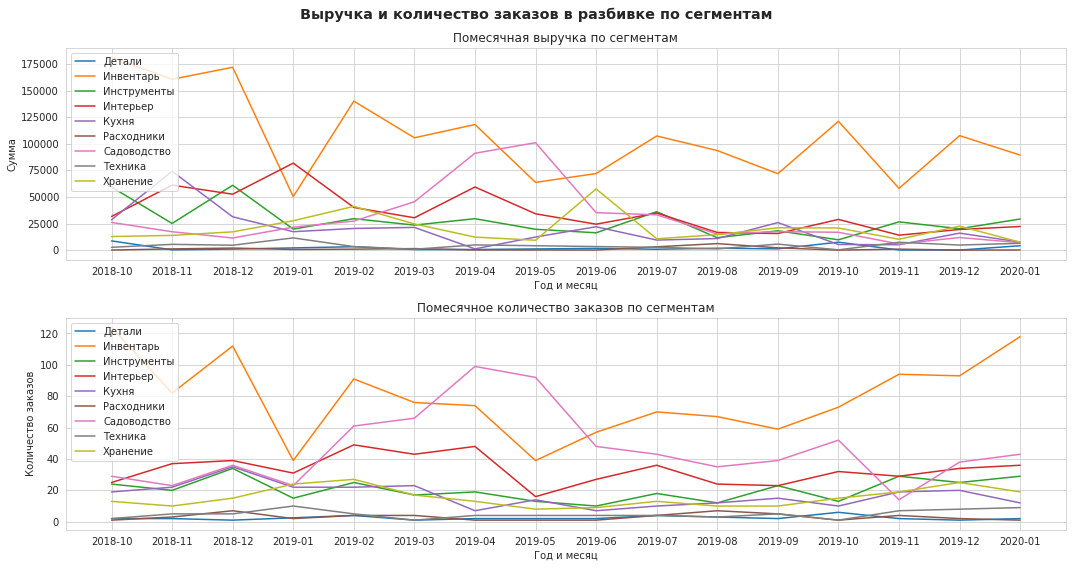

In [78]:
fig, axs = plt.subplots(nrows=2 , ncols=1, figsize=(15, 8))
fig.suptitle('Выручка и количество заказов в разбивке по сегментам',
             size='x-large', fontweight='semibold')

sns.lineplot(data=orders.groupby(['month','segm'], as_index=False)
                   .agg({'revenue':'sum'}),
             x='month', y='revenue', hue='segm', ax=axs[0])
axs[0].legend(loc='upper left')
axs[0].set_title('Помесячная выручка по сегментам')
axs[0].set_xlabel('Год и месяц')
axs[0].set_ylabel('Сумма')

sns.lineplot(data=orders.groupby(['month','segm'], as_index=False)
                   .agg({'order_id':'nunique'}),
             x='month', y='order_id', hue='segm', ax=axs[1])
axs[1].legend(loc='upper left')
axs[1].set_title('Помесячное количество заказов по сегментам')
axs[1].set_xlabel('Год и месяц')
axs[1].set_ylabel('Количество заказов')
plt.tight_layout()

Динамика сегментов схожа с динамикой продаж по товарным категориям, и это подтверждает то, что сегменты на их основе были верно выделены.  
Все сегменты имеют одинаковую активность вне зависимости от сезона за исключением сегмента любителей *Садоводства*.  
Значит, что им будут любопытны сезонные рекомендации.  

Для каждого сегмента также посмотрю топ-2 категорию интересующих товаров, так как в персонализированных предложениях может быть полезно предлагать не только ту товарную категорию, которая совпадает с сегментом. 

In [79]:
print('\033[1m'+'Вторые по популярности категории для сегментов')
(orders.groupby(['segm','category'], as_index=False).agg({'revenue':'sum'})
 .sort_values(['segm','revenue'], ascending=[True, False])
).groupby('segm').nth(1)[['category']]

Вторые по популярности категории для сегментов


,category
segm,
Детали,Инструменты
Инвентарь,Интерьер
Инструменты,Инвентарь
Интерьер,Кухня
Кухня,Хранение
Расходники,Кухня
Садоводство,Интерьер
Техника,Инвентарь
Хранение,Садоводство


По два раза встречаются товары из категории *Инвентарь*, *Интерьер* и *Кухня*.
<br> *Инвентарные* товары также интересны сегментам *Инструменты* и *Техника*.  
<br> *Интерьерные* - сегментам *Инвентарь* и *Садоводство*.  
<br> *Кухонные* - сегментам *Интерьер* и *Расходники*.  
<br> *Инструменты* также интересны сегменту *Детали*, что соответствует логике.
<br> *Хранение* интересно тем, кто обустраивает *Кухню*.  
<br> И *Садоводство* может быть интересно тем, кто покупал предметы *Хранения*.

### Вывод сегментации пользователей

Сегментация была проведена тремя методами: по среднему чеку, по количеству заказов, по тованым категориям.  

**Сегментация по чеку**  
В рамках этого метода пользователи были поделены на пользователей с низким, средним и высоким чеком.  
К низким относятя те, у кого средний чек до 405 руб.  
К средним те, у кого средний чек от 405 до 1049 руб.  
К высоким те, у кого средний чек от 1050 руб.  
Этот метод сегментации не подходит бизнесу, так как 64% пользователей совершило только один заказ, и опередлять платежеспособность клиента только по одному заказу и делать предложения, основываясь лишь на цене товаров нерационально.  

**Сегментация по количеству заказов**  
Как было сказано, пользователи редко совершают больше 1 заказа, и этот метод сегментации точно не подходит бизнесу.  

**Сегментация по товарным категориям**  
Пользователи делятся на сегменты по тем товарным категориям, на которые потратили больше всего денег.  
Самые многочисленные сегменты - Инвентарь, Садоводство и Интерьер.  
Разбивка по категориям отражает интересы покупателя и облегчает формулирование рекомендаций.  

**Изучение сегментов по товарной категории**  
Сезонные предложения больше всего будут интересны тем, кто покупает в магазине растения и семена.  
Также для сегментов были найдены другие категории, которые им могут быть интересны, основываясь на сумме покупок в категориях.  
Для тех, кто покупает Детали - это Инструменты.  
Для покупателей Инструментов, Техники - это Инвентарь.  
Для покупателей Интерьера и Расходников - это Кухня.  
Для покупателей Инвентаря и Садоводства - это Интерьер.  
И для Кухни - это Хранение.

## Статистическая проверка гипотез

Чтобы лучше понимать сегменты - проведу статистическую проверку гипотез.  

### Гипотеза о равенстве количества заказов

Сначала проверю, есть ли статистическая разница в количестве заказов у клиентов из разных сегментов.  
Возьму только те сегменты, где количество пользователей больше 150 и проведу тест по критерию Манна-Уитни для каждого сегмента (так как распределение отличается от нормального).  
Уровень значимости приму в 0,05.  

*Нулевая гипотеза:* количество заказов в сегментах одинаково.  
*Альтернативная гипотеза:* количество заказов в сегментах неодинаково.

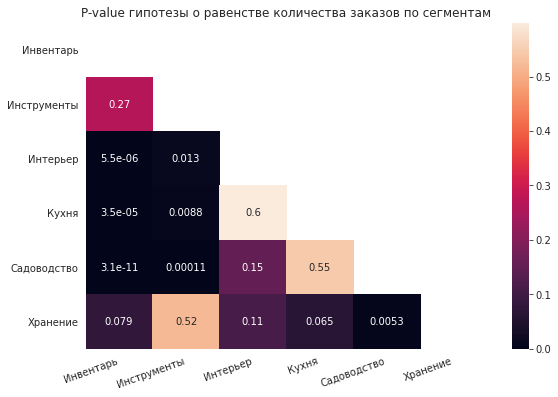

In [80]:
segments = (segm_by_category.groupby('segm')
            .agg({'customer_id':'nunique'})
            .query('customer_id > 150').index.tolist())
for_test = segm_by_category[['segm','order_id']].query('segm in @segments')

# сгруппированные данные по сегментам понадобятся при проверке
grouped = for_test.groupby('segm')

# в этой таблице будут храниться значения проверки гипотез
p_value_table = pd.DataFrame(index=segments, columns=segments)

# проверю каждый сегмент с другими сегментами
for segment1, group1 in grouped:
    for segment2, group2 in grouped:
        if segment1 != segment2:
            statistics, p_value = st.mannwhitneyu(group1['order_id'],
                                                  group2['order_id'])
            p_value_table.at[segment1, segment2] = p_value

# выделю те p-value, которые меньше 0,05
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(p_value_table.fillna(1), annot=True, fmt='.2',
            mask=np.triu(np.ones(p_value_table.shape)))
plt.title('P-value гипотезы о равенстве количества заказов по сегментам')
plt.xticks(rotation=20, ha='right');

Количество заказов статистически разное между (p-value < 0.05):  
Интерьером и Инвентарем, Инструментами  
Кухней и Инвентарем, Инструментами  
Садоводством и Инвентарем, Инструментами, Хранением.

In [81]:
print('\033[1m'+'Среднее количество заказов по сегментам')
for_test.groupby('segm').agg({'order_id':'mean'}).sort_values('order_id',ascending=False)

Среднее количество заказов по сегментам


,order_id
segm,
Инвентарь,1.694779
Инструменты,1.419214
Хранение,1.387640
Интерьер,1.329975
Садоводство,1.305115
Кухня,1.300971


Судя по средним значениям и p-value гипотез - выделяются именно Инвентарь и Инструменты, в которых заказов больше чем у ряда сегментов, и это подтверждается p-value, которое говорит о разности количества заказов.

### Гипотеза о равенстве средних чеков

Альтернативно проверю гипотезу о средних чеках.  
Уровень значимости = 0.05

*Нулевая гипотеза:* средний чек в сегментах одинаков.  
*Альтернативная гипотеза:* средний чек в сегментах неодинаков.

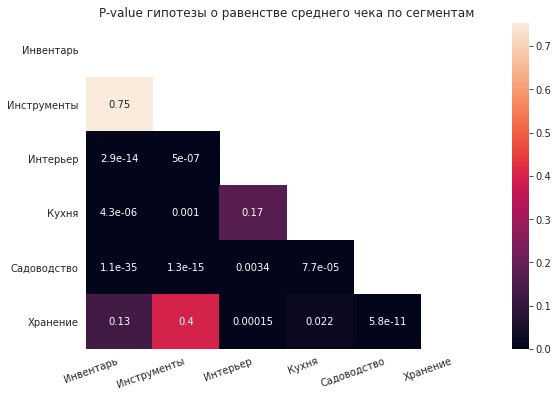

In [82]:
segments = (segm_by_category.groupby('segm')
            .agg({'customer_id':'nunique'})
            .query('customer_id > 150').index.tolist())
for_test = segm_by_category[['segm','revenue']].query('segm in @segments')

grouped = for_test.groupby('segm')

p_value_table = pd.DataFrame(index=segments, columns=segments)

for segment1, group1 in grouped:
    for segment2, group2 in grouped:
        if segment1 != segment2:
            statistics, p_value = st.mannwhitneyu(group1['revenue'],
                                                  group2['revenue'])
            p_value_table.at[segment1, segment2] = p_value

fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(p_value_table.fillna(1), annot=True, fmt='.2',
            mask=np.triu(np.ones(p_value_table.shape)))
plt.title('P-value гипотезы о равенстве среднего чека по сегментам')
plt.xticks(rotation=20, ha='right');

Категории, между которыми нет различий по среднему чеку - это:  
Хранение и Инвентарь, Инструменты.  
Кухня и Интерьер.  
Инструменты и Инвентарь.

In [83]:
print('\033[1m'+'Средний чек по сегментам')
for_test.groupby('segm').agg({'revenue':'mean'}).sort_values('revenue', ascending=False)

Средний чек по сегментам


,revenue
segm,
Хранение,1568.938904
Инвентарь,1448.197430
Инструменты,1392.644105
Кухня,1227.616100
Интерьер,1062.559194
Садоводство,729.136050


Различия в среднем чеке выражены сильнее, поэтому между многими категориями (между 11 парами из 15) присутствуют статистически значимые различия.

## Рекомендации по сегментам

Сегменты были выделены через товарные категории, на которые пользователь потратил больше всего денег.  
Всего есть девять сегментов:  
Детали, Инвентарь, Инструменты, Интерьер, Кухня, Расходники, Садоводство, Техника, Хранение.

In [84]:
print('\033[1m'+'Количество пользователей по сегментам')
segm_by_category.groupby('segm').agg({'customer_id':'nunique'}).sort_values('customer_id', ascending=False)

Количество пользователей по сегментам


,customer_id
segm,
Инвентарь,747
Садоводство,567
Интерьер,397
Инструменты,229
Кухня,206
Хранение,178
Техника,43
Расходники,35
Детали,27


Больше всего пользователей в сегментах: Инвентарь, Садоводство и Интерьер.  
8 из 9 сегментов не показали выраженной сезонности спроса.  
Только в сегменте *Садоводство* продажи резко растут в апреле и мае. Поэтому клиентам в данном сегменту будут интересны сезонные предложения и сообщения о новинкам в апреле и мае.  
Соответственно, другим сегментам также можно делать персонализированные предложения, касающихся товаров интересующей категории.  

83% пользователей вовзращается за повторным заказом в срок от 100 дней и более.  
Поэтому персонализированные предложения стоит делать не ранее чем через 3 месяца после первого заказа, так как специфика продукции не подразумевает постоянных покупок.  
Чаще можно делать предложения сегментам, которые делают больше покупок - это *Инвентарь* и *Инструменты*.  
Также в предложениях стоит учитывать наиболее распространенный ценовой диапозон товаров в сегментах.  

При наполнении ленты магазина для пользователя - в первую очередь следует показывать товары, соответсвующие сегменту клиента, но также для разнообразия стоит включить вторую по популярности категорию товаров и прочие.

In [85]:
print('\033[1m'+'Вторые по популярности категории для сегментов')
(orders.groupby(['segm','category'], as_index=False).agg({'revenue':'sum'})
 .sort_values(['segm','revenue'], ascending=[True, False])
).groupby('segm').nth(1)[['category']]

Вторые по популярности категории для сегментов


,category
segm,
Детали,Инструменты
Инвентарь,Интерьер
Инструменты,Инвентарь
Интерьер,Кухня
Кухня,Хранение
Расходники,Кухня
Садоводство,Интерьер
Техника,Инвентарь
Хранение,Садоводство


## Вывод

### Исследовательский анализ

**Общий обзор данных**  
Данные собраны за период от октября 2018 до января 2020 года.  
Выручка за это время колеблется от 150 до 300 тыс. в месяц, а количество заказов от 160 до 280 в месяц.  
За три месяца 2018 года выручка достигала самых высоких значений в районе 350 тыс. руб., затем резко снизилась до 240 тыс. в январе 2019. За 2019 год самая высокая выручка была в апреле и достигла около 315 тыс. К концу 2019 выручка снижалась и достигла минимального значения в 130 тыс. в ноябре.  
Количество заказов в основном подчинялось динамике выручки и снижалось к сентябрю 2019, после чего начало показывать устойчивые темпы роста.  

При этом за 2019 год средний чек был достиг самого высокого значения в июне месяце и составил 1400 руб., после чего начал снижаться.  
Средний чек изменялся в диапозоне от 600 руб. (ноябрь 2019) до 1700 руб. (ноябрь 2018).  
С октября 2018 по октябрь 2019 почти все заказы совершали новые пользователи, а с ноября 2019 новые пользователи перестали приходить, и заказы совершали те же клиенты, что обращались за услугами магазина ранее.  

**Изучение покупателей**  
Всего в наборе данных собрана информация о 2429 клиентах.  

Большинство пользователей совершило не более 3 заказов за исследуемый период.  
**64%** клиентов совершило лишь одну покупку, 34% более одной.  
Треть повторных заказов было совершено в тот же день, что и первый. Никто не совершает повторный заказ через 50-100 дней, но покупатели возвращаются в течение 101-390 дней.  

Заказы в основном ограничваются суммой до 2810 рублей.  

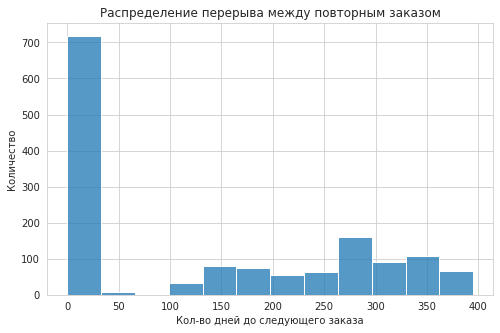

In [86]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(repeated_orders['timediff'])
plt.title('Распределение перерыва между повторным заказом')
plt.xlabel('Кол-во дней до следующего заказа')
plt.ylabel('Количество');

**Исследование категорий**  
Самая продаваемая категория - *Садоводство*. Товары из этой категории продались более 2500 раз. Категории *Инвентарь* около 1000 раз, *Интерьер* около 650.  
Самые непопулярные категории - *Расходники*, *Техника* и *Детали*.  

Самые дорогие категории товаров - *Инвентарь* (медианная цена 749 руб.), *Техника* (749), *Инструменты* (637).  
Самые дешевые - *Садоводство* (120), *Расходники* (104) и *Детали* (48)  

Самая высокая кумулятивная выручка - у товаров из категории *Инвентарь* (1 590 841 руб.). Следом за ним - *Интерьер* (591 тыс.), *Садоводство* (522 тыс.)  
Самая низкая - у *Техники* (62 тыс.), *Деталей* (37 тыс.) и у *Расходников* (20 тыс.)  
Кумулятивная выручка заметно растет у *Садоводства* в период с мая по июнь, другие категории не имеют выраженних пиков роста.  
Сезонность также выражена только у этой категории товаров.

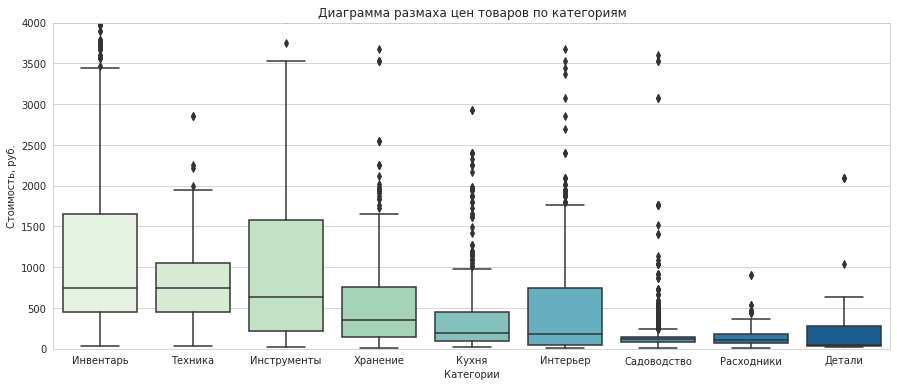

In [87]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxplot(data=orders, y='price', x='category', palette='GnBu',
            order=orders.groupby('category').agg({'price':'median'})
                  .sort_values('price', ascending=False).index.tolist())
plt.ylim(0, 4000)
plt.title('Диаграмма размаха цен товаров по категориям')
plt.xlabel('Категории')
plt.ylabel('Стоимость, руб.');

### Сегментация пользователей

**Сегментация по чеку**  
В рамках этого метода пользователи были поделены на пользователей с низким, средним и высоким чеком.  
К низким относятя те, у кого средний чек до 405 руб.  
К средним те, у кого средний чек от 405 до 1049 руб.  
К высоким те, у кого средний чек от 1050 руб.  
Этот метод сегментации не подходит бизнесу, так как 64% пользователей совершило только один заказ, и опередлять платежеспособность клиента только по одному заказу и делать предложения, основываясь лишь на цене товаров нерационально.

**Сегментация по количеству заказов**  
Как было сказано, пользователи редко совершают больше 1 заказа, и этот метод сегментации точно не подходит бизнесу.

**Сегментация по товарным категориям**  
Пользователи делятся на сегменты по тем товарным категориям, на которые потратили больше всего денег.  
Самые многочисленные сегменты - Инвентарь, Садоводство и Интерьер.  
Разбивка по категориям отражает интересы покупателя и облегчает формулирование рекомендаций.  

In [88]:
pd.DataFrame(segm_by_category.groupby('segm').agg({'customer_id':'nunique',
                                                   'revenue':'median',
                                                   'order_id':'median'})
             .sort_values('customer_id', ascending=False)
             .rename(columns={'customer_id':'Кол-во клиентов',
                              'revenue':'Медианный чек',
                              'order_id':'Мед. кол-во заказов'})
            ).style.background_gradient('GnBu').format({'Медианный чек':'{0:.1f}'})

,Кол-во клиентов,Медианный чек,Мед. кол-во заказов
segm,,,
Инвентарь,747,876.5,1
Садоводство,567,412.0,1
Интерьер,397,550.5,1
Инструменты,229,929.0,1
Кухня,206,594.0,1
Хранение,178,791.0,1
Техника,43,779.5,2
Расходники,35,208.0,1
Детали,27,592.0,1


### Статистическая проверка гипотез

Были проверены гипотезы о равенстве количества заказов и средних чеков между сформированными сегментами.  
Количество заказов не сильно изменяется от сегмента к сегменту, однако статистически значимые различия были выявлены для категорий Инвентарь и Инструменты в 3 парах из 5.  
Принимая во внимание также среднее количество заказов по сегментам – можно заключить, что сегменты Инвентарь и Интерьер действительно могут приносить большее количество заказов, чем прочие.  
Различия в среднем чеке выражены сильнее. Нет различий только между следующими сегментами:  
Инструменты и Хранение, Инструменты и Инвентарь, Инвентарь и Хранение, Кухня и Инвентарь.  
Средние значения чека у сегментов Инструменты, Хранение и Инвентарь входят в топ-3 по величине.  
Что может означать, что эти три сегмента, которые не имеют статистически значимых различий между друг другом и имеют высокий средний чек – могут быть ключевыми сегментами для магазина, так как сильно влияют на формирование выручки.

### Общие рекомендации бизнесу

**Привлечение новых пользователей**  
С ноября 2019 года резко сократился прирост новых клиентов.  
Важно поддерживать приток новых клиентов, особенно когда старые клиенты очень возвращаются за покупками через 3 и более месяцев.

**Лояльность клиентов**  
Возможным решением, которое позволит увеличить выручку является работа над лояльностью клиентов.  
Внедрение программы лояльности может побудить покупателей делать покупки регулярнее.  

**Оптимизация ассортимента**  
В магазине есть ряд категорий, которые приносят мало выручки и редко покупаются. Это - Детали и Расходники.  
Скорее всего за этими категориями товаров люди привыкли обращаться в ближайшие магазины у дома. Закупка и хранение этих категорий товаров может быть лишней тратой средств.  
Категория Техника также приносит низкую выручку, что также может быть связано с тем, что потребители при покупке техники привыкли обращаться в специализированные магазины.

### Рекомендации по взаимодействию с сегментами

8 из 9 сегментов не показали выраженной сезонности спроса.  
Только в сегменте Садоводство продажи резко растут в апреле и мае. Поэтому клиентам в данном сегменту будут интересны сезонные предложения и сообщения о новинкам в апреле и мае.  
Соответственно, другим сегментам также можно делать персонализированные предложения, касающихся товаров интересующей категории.  

83% пользователей вовзращается за повторным заказом в срок от 100 дней и более.  
Поэтому персонализированные предложения стоит делать не ранее чем через 3 месяца после первого заказа, так как специфика продукции не подразумевает постоянных покупок.  
Чаще можно делать предложения сегментам, которые делают больше покупок - это Инвентарь и Инструменты. Также в предложениях стоит учитывать наиболее распространенный ценовой диапозон товаров в сегментах.  

При наполнении ленты магазина для пользователя - в первую очередь следует показывать товары, соответсвующие сегменту клиента, но также для разнообразия стоит включить вторую по популярности категорию товаров и прочие.

In [89]:
print('\033[1m'+'Вторые по популярности категории для сегментов')
(orders.groupby(['segm','category'], as_index=False).agg({'revenue':'sum'})
 .sort_values(['segm','revenue'], ascending=[True, False])
).groupby('segm').nth(1)[['category']]

Вторые по популярности категории для сегментов


,category
segm,
Детали,Инструменты
Инвентарь,Интерьер
Инструменты,Инвентарь
Интерьер,Кухня
Кухня,Хранение
Расходники,Кухня
Садоводство,Интерьер
Техника,Инвентарь
Хранение,Садоводство
